# Adhesive Simulation of the contact of a sphere

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from SurfaceTopography import Topography
from Adhesion.Interactions import PowerLaw
from Adhesion.System import BoundedSmoothContactSystem
from ContactMechanics.Tools.Logger import screen, Logger
from SurfaceTopography.Special import make_sphere
from NuMPI.IO.NetCDF import NCStructuredGrid
from Adhesion.ReferenceSolutions import JKR


Nondimensionalisation using the JKR units following the convensions in Maugis' book.
See https://contactengineering.github.io/Adhesion/source/Adhesion.ReferenceSolutions.html#module-Adhesion.ReferenceSolutions.JKR and/or https://doi.org/10.1016/j.jmps.2022.104781 , https://doi.org/10.1088/0022-3727/41/16/163001

In [2]:
R = 1
w = 1/ np.pi 
Es = 3/4

## Prepare Geometry

<ipython-input-3-6bb12aa4f1e9>:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(ax.pcolormesh(x * np.ones_like(y), y * np.ones_like(x), t.heights()), label = "heights")


Text(0, 0.5, 'y ($z_0$)')

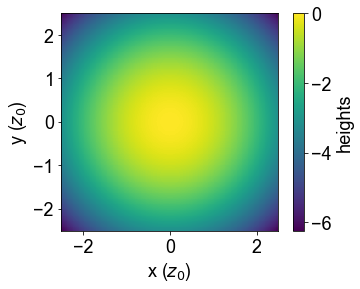

In [3]:
nx, ny = 256,256

sx = 5
sy = 5 

x = np.arange(0, nx).reshape(-1,1 ) * sx/nx - sx / 2
y = np.arange(0, ny).reshape(1,-1 ) * sy/ny - sy / 2

t = make_sphere(radius=R, nb_grid_pts=(nx, ny), physical_sizes=(sx , sy), kind="paraboloid")

fig, ax = plt.subplots()
plt.colorbar(ax.pcolormesh(x * np.ones_like(y), y * np.ones_like(x), t.heights()), label = "heights")
ax.set_aspect(1)
ax.set_xlabel("x ($z_0$)")
ax.set_ylabel("y ($z_0$)")

Text(0, 0.5, 'heights ($z_0$)')

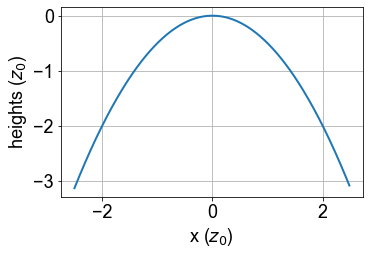

In [4]:
fig, ax = plt.subplots()
ax.plot(x, t.heights()[:, ny//2])
ax.set_aspect(1)
ax.set_xlabel("x ($z_0$)")
ax.set_ylabel("heights ($z_0$)")

## setup system

### Choosing appropriate discretization

I did a study to determine good interaction parameters: 

/Users/antoines/Documents/2008_hardwall_sphere_convergence_jkr/discretisation_hysteresis_overview

Problem: the datasets arre with hardcoded path and I deleted them, it's a bit struggle to find them again...

The whole project was about convergence of rings and rays with interaction range.

/Users/antoines/Documents/2008_hardwall_sphere_convergence_jkr

old version only on exponential

/Users/antoines/Documents/1910_hardwall_exponential_discretization/Discretization hysteresis.html



Guideline for appropriate discretisation. 

With the exponential and the cubic interaction potential close to the JKR limit, the pixel size needs to be smaller than $2\rho^2$ (in JKR units).

$$
dx \leq 2 \rho^2 \frac{4}{3\pi} \frac{1}{\ell_a}
$$

with $\ell_a = w_{int} / E^\prime$


see c83b545e-1385-47a7-adc6-ac9a24c02e39 discretisation_hysteresis_overview.html

for the empirical determination.


In [5]:
interaction_range = 0.2

In [6]:
t.pixel_size / interaction_range**2

array([0.48828125, 0.48828125])

In [7]:
# cubic interaction potential
interaction = PowerLaw(w,
                        # v that way the max stress is still w / rho
                        3 * interaction_range,
                        3)

In [8]:
system = t.make_contact_system(
    interaction=interaction,
    system_class=BoundedSmoothContactSystem,
    young=Es
           )

#### loading history

In [9]:
def penetrations(start_pen, max_pen, dpen):
    """
    The advantage of using this function is that it generates penetrations that are exactly the same during approach and retraction. 
    
    naively incrementing like `penetration += dpen` gives slightly different values due to numerical roundoff errors.
    """
    i = 0  # integer penetration value
    pen = start_pen + dpen * i
    yield pen
    while pen < max_pen:
        i += 1
        pen = start_pen +dpen * i
        yield pen
    while True:
        i -= 1
        pen = start_pen + dpen * i
        yield pen

In [10]:
start_pen = - interaction.cutoff_radius # before the jump into contact instability
max_pen=1.5
dpen = 0.2

### Simulate

Choice of the gradient tolerance: The gradient is the error in the balance 
of the elastic-force and the adhesive force on each pixel. 

This error should be small compared to this force. 

For simulations with adhesion close to the JKR limit, the maximum stress is usually given by the interaction. 

In the DMT regime, it would be given by the contact 
 

In [11]:
gtol = 1e-4 * abs(interaction.max_tensile) * t.area_per_pt

In [12]:

# create outputfile
ncfilename="sphere_simulation_hardwall_cubic.nc"
nc = NCStructuredGrid(ncfilename, "w", nb_domain_grid_pts=t.nb_grid_pts)

disp0=None
i=0
penetration_prev = -10
i = 0
for penetration in penetrations(start_pen, max_pen, dpen):
    
    print(f"penetration = {penetration}")
    sol = system.minimize_proxy(                                       
        initial_displacements=disp0,                                                                                       
        options=dict(gtol=gtol, # max absolute value of the gradient of the objective for convergence 
                     ftol=0, # stop only if the gradient criterion is fullfilled
                     maxcor=3 # number of gradients stored for hessian approximation
                    ),                               
        logger=Logger("laststep.log"),                                 
        offset=penetration,                                           
        callback=None,                                                 
                )
    assert sol.success, sol.message
    disp0 = u = system.disp 
    
    # dumping results
    fr = nc[i]
    fr.penetration = penetration
    fr.normal_force = system.compute_normal_force()
    fr.contact_area =system.compute_contact_area()
    fr.repulsive_area = system.compute_repulsive_contact_area()
    fr.pressures = - system.substrate.evaluate_force(u)[system.substrate.topography_subdomain_slices] / system.area_per_pt
    fr.elastic_displacements = system.disp[system.surface.subdomain_slices] 
    

    if penetration < penetration_prev and fr.contact_area == 0:
        print("left contact")
        break 
    penetration_prev = penetration
    
    i+=1
nc.close()

penetration = -0.6000000000000001
penetration = -0.4000000000000001
penetration = -0.20000000000000007
penetration = 0.0
penetration = 0.19999999999999996
penetration = 0.3999999999999999
penetration = 0.6000000000000001
penetration = 0.8
penetration = 1.0
penetration = 1.2
penetration = 1.4
penetration = 1.6
penetration = 1.4
penetration = 1.2
penetration = 1.0
penetration = 0.8
penetration = 0.6000000000000001
penetration = 0.3999999999999999
penetration = 0.19999999999999996
penetration = 0.0
penetration = -0.20000000000000007
penetration = -0.4000000000000001
penetration = -0.6000000000000001
penetration = -0.8
penetration = -1.0
left contact


## plot pressure distributions and deformed profiles

In [13]:
nc = NCStructuredGrid(ncfilename)

<ipython-input-14-f33233a37a57>:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(axf.pcolormesh(*t.positions(), nc.pressures[i, ...]), label="pressures", ax = axf)
<ipython-input-14-f33233a37a57>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (axf, axfcut, axtopcut) = plt.subplots(1,3, figsize=(14,3))


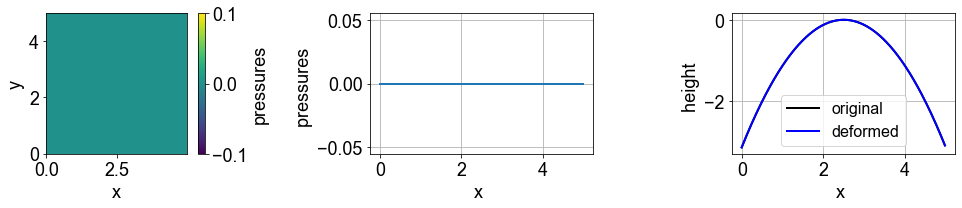

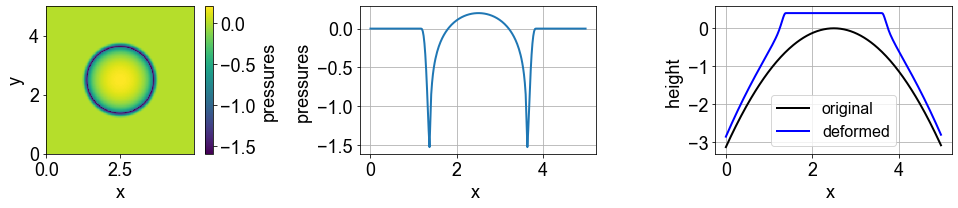

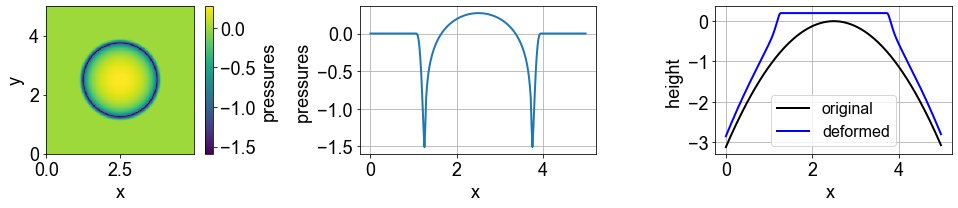

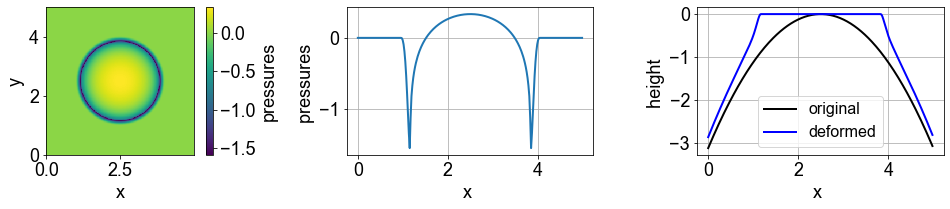

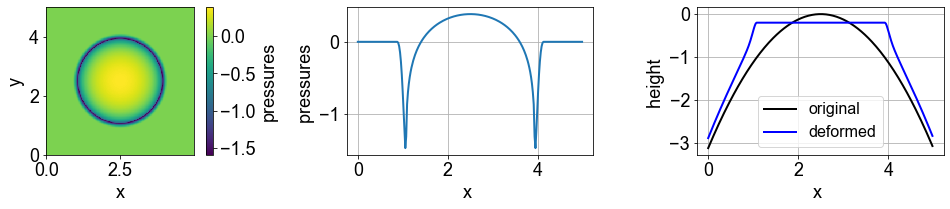

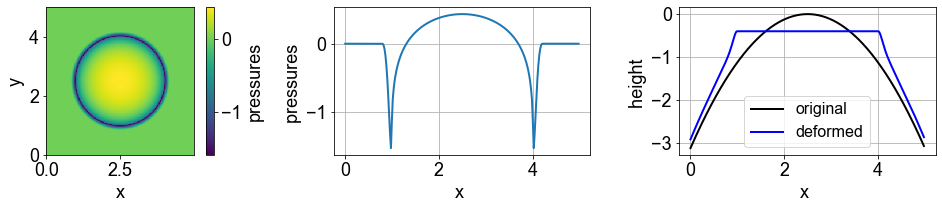

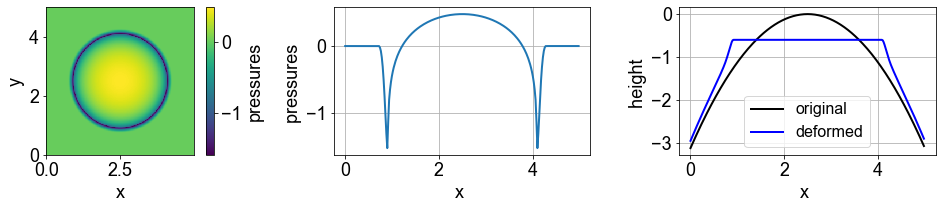

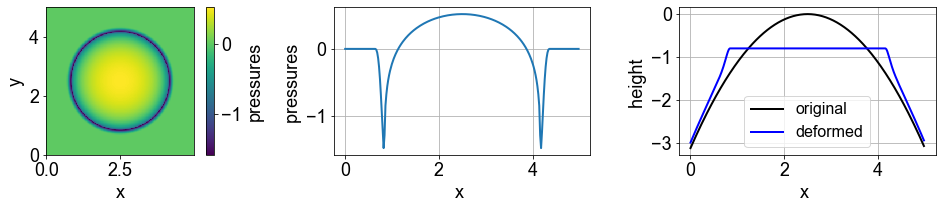

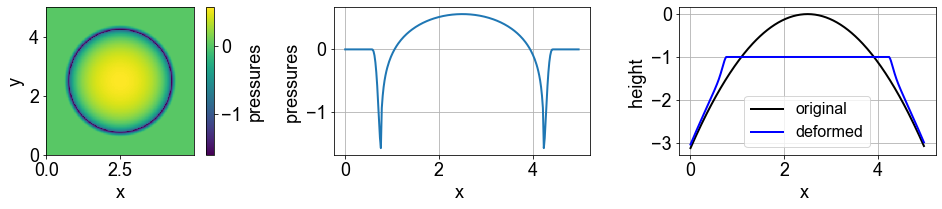

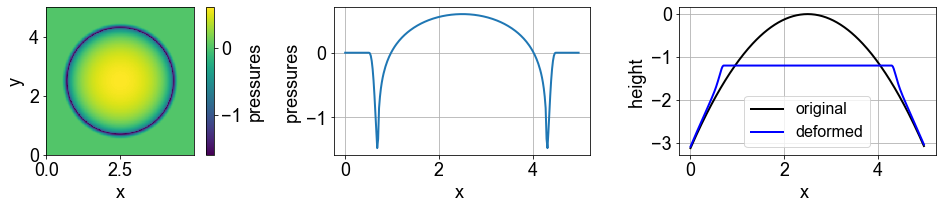

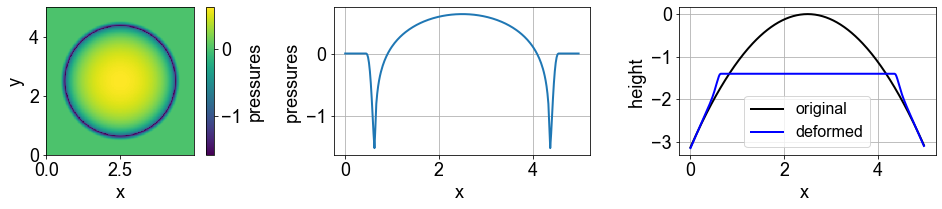

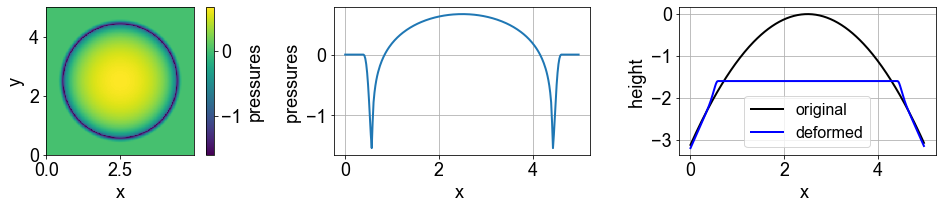

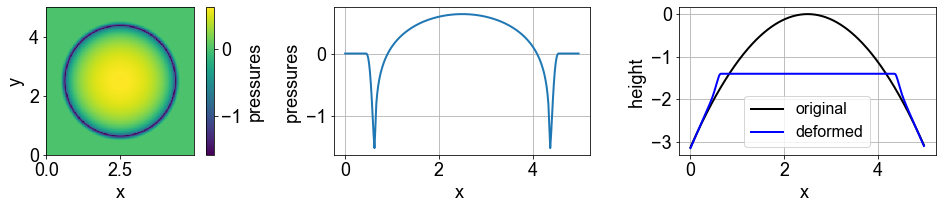

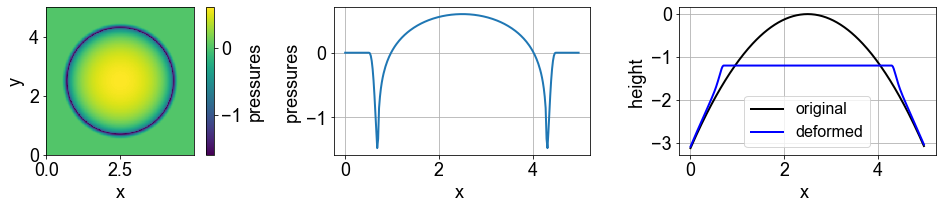

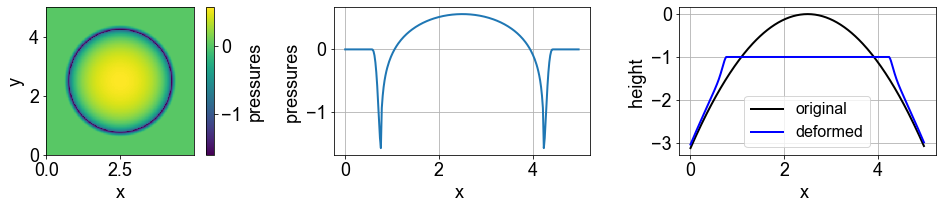

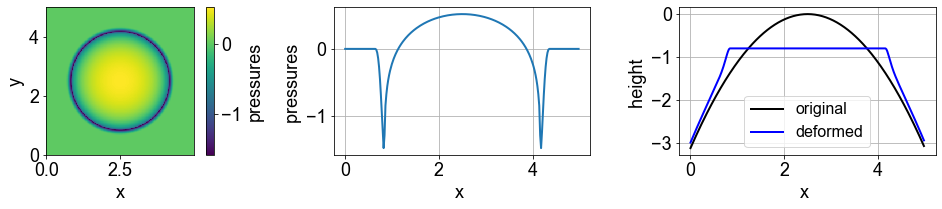

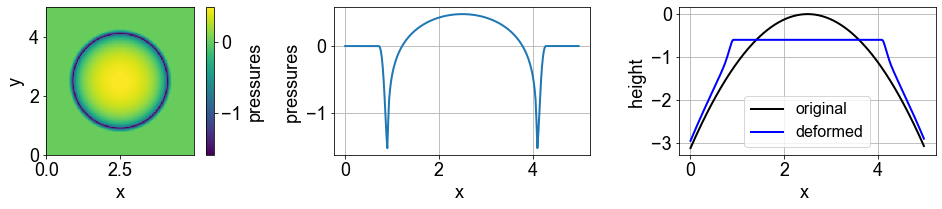

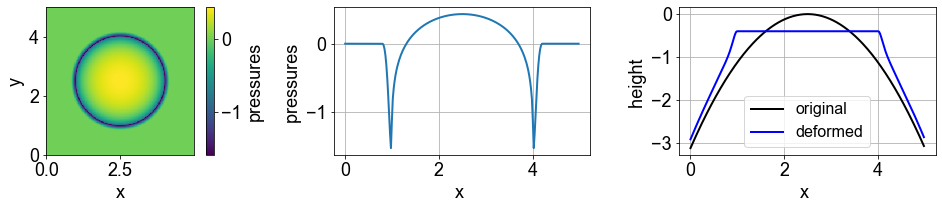

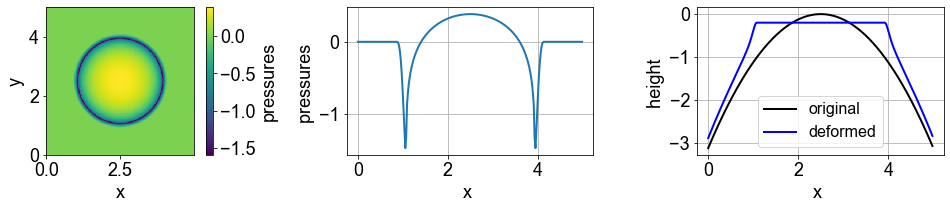

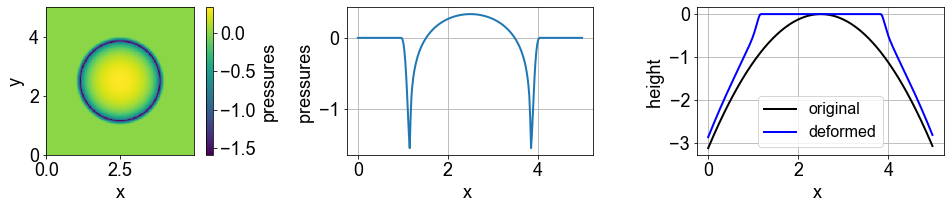

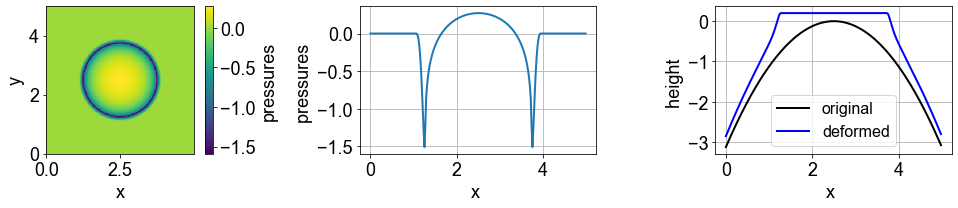

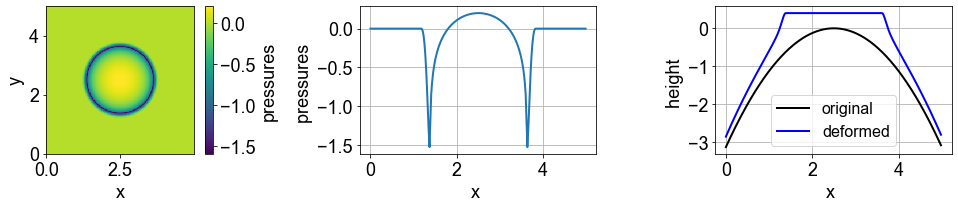

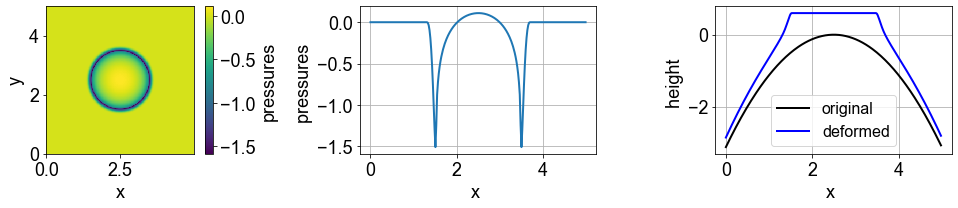

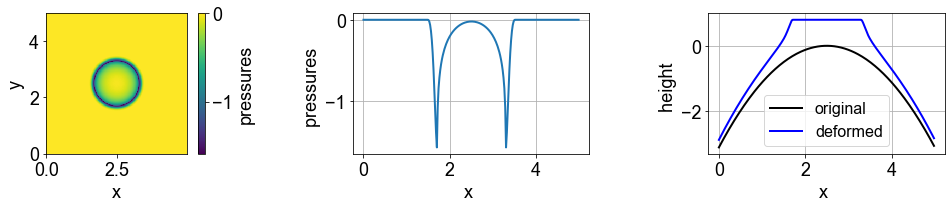

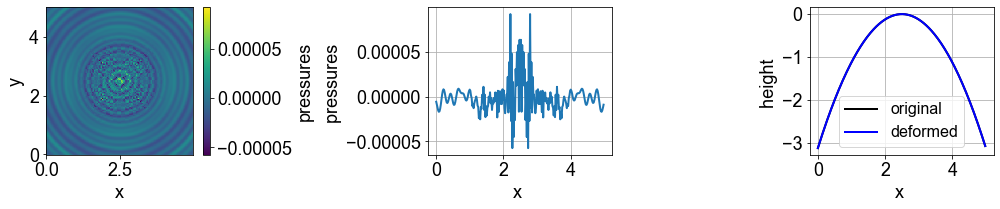

In [14]:
for i in range(len(nc)):
    
    fig, (axf, axfcut, axtopcut) = plt.subplots(1,3, figsize=(14,3))
    
    axf.set_xlabel("x")
    axf.set_ylabel("y")
        
    axfcut.plot(t.positions()[0][:,0], nc.pressures[i, :, ny//2])
    axfcut.set_xlabel("x")
    axfcut.set_ylabel("pressures ")
    
    for a in (axfcut, axtopcut):
        a.set_xlabel("x ")
    axtopcut.set_ylabel("height ")
    
    plt.colorbar(axf.pcolormesh(*t.positions(), nc.pressures[i, ...]), label="pressures", ax = axf)
    axf.set_aspect(1)
    
    axtopcut.plot(t.positions()[0][:,0], t.heights()[:, ny//2], 
                  color="k", label = "original")
    axtopcut.plot(t.positions()[0][:,0], t.heights()[:, ny//2] - nc.elastic_displacements[i,:, ny//2], 
                  c="b", label="deformed")
    axtopcut.legend()
    
    fig.tight_layout()

Note that the pressures you see in the last plot are the numerical errors.

## Scalar quantities during loading

Text(0, 0.5, 'Force $F^{*}$')

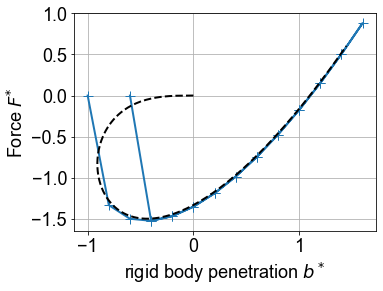

In [15]:
fig, ax = plt.subplots()

ax.plot(nc.penetration[:], nc.normal_force[:],"+-")

contact_radii = np.linspace(0,np.max(np.sqrt(nc.contact_area[:]/np.pi)),200)
ax.plot(JKR.penetration(contact_radius=contact_radii),JKR.force(contact_radius=contact_radii), "--k", label="JKR")
ax.set_xlabel("rigid body penetration $b^*$")
ax.set_ylabel("Force $F^{*}$")

TODO: it is strange that the sphere already feels interaction at -0.8, which is less than the range of interaction.

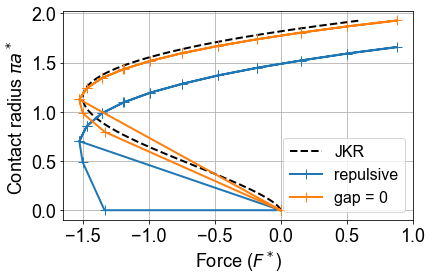

In [16]:
fig, ax = plt.subplots()

contact_radii = np.linspace(0,np.max(np.sqrt(nc.contact_area[:]/np.pi)),200)
ax.plot(JKR.force(contact_radius=contact_radii), contact_radii, "--k", label="JKR")

ax.plot(nc.normal_force[:], np.sqrt(nc.repulsive_area[:] / np.pi), "+-", label="repulsive")
ax.plot(nc.normal_force[:], np.sqrt(nc.contact_area[:] / np.pi), "+-", label="gap = 0")
ax.set_xlabel(r"Force ($F^*$)")
ax.set_ylabel(r"Contact radius $\pi a^*$ ")
fig.tight_layout()
ax.legend()